# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Introduction</p>
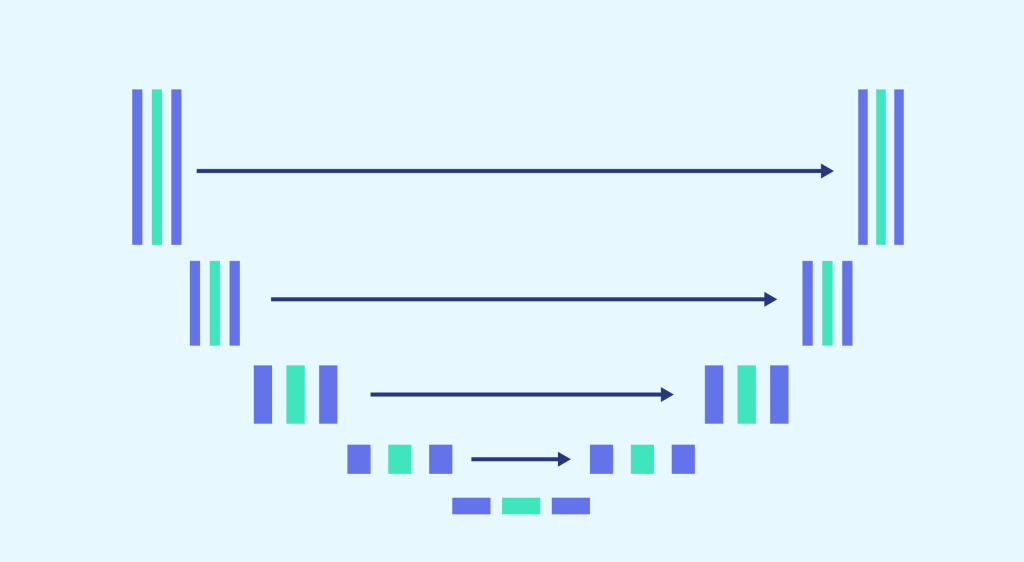

U-Net is a deep learning architecture specifically designed for biomedical image segmentation. Introduced in 2015 by Olaf Ronneberger et al., it has become a foundational model in the field due to its effectiveness in delineating complex structures in medical images.

## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Key Features</p>
1. **Architecture**: U-Net consists of a contracting path (encoder) and an expansive path (decoder), creating a U-shaped structure. The encoder captures context through downsampling, while the decoder enables precise localization by upsampling. Skip connections between corresponding layers in the encoder and decoder allow for the preservation of spatial information, crucial for accurate segmentation.
2. **Data Efficiency**: U-Net is designed to work well with relatively few training images. This is particularly important in the biomedical field, where labeled data can be scarce. The model uses data augmentation techniques to enhance training and improve generalization.
3. **Applications**: U-Net is widely used for segmenting various biomedical images, including:

   - **MRI and CT scans**: For identifying tumors, lesions, and organ boundaries.

   - **Histopathology images**: For detecting cellular structures and classifying tissue types.

   - **Cell segmentation**: In microscopy images, for tasks like identifying individual cells and their components.
4. **Performance**: The architecture has been shown to achieve high accuracy and robustness in various segmentation tasks, often outperforming traditional methods. Its ability to produce precise pixel-wise predictions makes it a preferred choice for medical image analysis.

## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Importing Libraries</p>

In [4]:
# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, metrics
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint

# Image Processing Libraries
import cv2
from cv2 import imread,resize
from scipy.ndimage import label, find_objects

# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# File and Operating System Libraries
import os

# Warnings Management
import warnings
warnings.filterwarnings('ignore')

# GPU Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(tf.config.list_physical_devices('GPU'))

# PATHS
IMG_PATH = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image/'
MSK_PATH = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/'

[]


# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Dataset Overview for Chest X-Ray Lungs Segmentation</p>
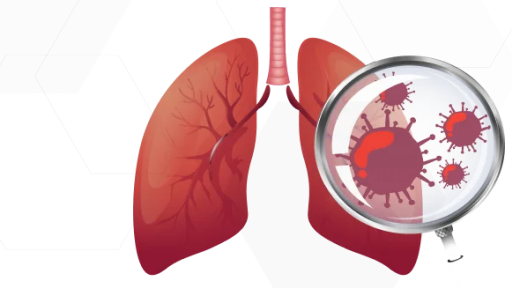

## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Dataset Description</p>
This dataset comprises **704 chest X-ray images** sourced from two prominent databases: the **Montgomery County Chest X-ray Database** (USA) and the **Shenzhen Chest X-ray Database** (China). It is designed for training and evaluating machine learning models, particularly in the detection of **tuberculosis (TB)**. The dataset includes both **tuberculosis-positive (PTB)** and **normal** chest X-rays, along with additional **clinical metadata** and **lung segmentation masks** for improved training of deep learning models.

With both **image segmentation** and clinical labels, the dataset is ideally suited for tasks involving **image classification** and **image segmentation**, making it a valuable resource for tuberculosis detection and general lung health analysis.

## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Data Sources</p>
1. **Montgomery County Chest X-ray Database** (USA)
   - Originates from the **Montgomery County, Maryland** Tuberculosis screening program.
   - Contains **58 TB-positive** and **80 normal** X-ray images.

2. **Shenzhen Chest X-ray Database** (China)
   - Collected from **out-patient clinics** in **Shenzhen, Guangdong Province**.
   - Includes **336 TB-positive** and **326 normal** X-ray images.

## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Dataset Statistics</p>
- **Total Number of Images**: 704 chest X-rays (from both Montgomery and Shenzhen).
- **County Distribution**:
  - **Shenzhen**: 80% (563 images).
  - **Montgomery**: 20% (141 images).
- **Tuberculosis Cases (PTB)**:
  - **PTB=1 (Tuberculosis Positive)**: 345 images.
  - **PTB=0 (Normal)**: 359 images.

## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Clinical Metadata Breakdown</p>
The dataset is accompanied by clinical metadata, which provides important information about each X-ray image. The columns in the metadata file (MetaData.csv) include:
- **id**: A unique identifier for each X-ray image.
- **gender**: Gender of the patient (male/female).
- **age**: The age of the patient.
- **county**: The geographic origin of the X-ray (Shenzhen or Montgomery).
- **ptb**: Label indicating whether the X-ray shows **tuberculosis (1)** or is **normal (0)**.
- **remarks**: Additional clinical notes about the patient's condition (e.g., "secondary PTB", "normal").

## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Data Structure</p>
The dataset is organized into the following directory structure:

```
/Chest-X-Ray/Chest-X-Ray
    /image/           # Contains all chest X-ray images
    /mask/            # Contains lung segmentation masks (if available)
    /MetaData.csv     # Clinical metadata file with patient and X-ray details
```

In [ ]:
metadata = pd.read_csv('/kaggle/input/chest-x-ray-lungs-segmentation/MetaData.csv')
metadata.info()

In [ ]:
metadata.head()

In [ ]:
agg_data = metadata.ptb.value_counts()
ct = pd.crosstab(metadata['gender'], metadata['ptb'])

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.pie(agg_data,labels=agg_data.index,autopct='%1.1f%%', startangle=90,colors=['darkorchid','tomato'])

plt.subplot(122)
bars = sns.countplot(metadata,x='ptb',hue='county',palette=['darkorchid','tomato'])
plt.bar_label(bars.containers[0], label_type='center')
plt.bar_label(bars.containers[1], label_type='center')
plt.yticks([])
plt.xticks([0,1],labels=['Negative','Positive'])
plt.xlabel('Tuberculosis')
plt.box(False)

plt.suptitle('PTB Analysis',fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
gender_mapping = {
    'm': 'male', 'Male,': 'male', 'male35yrs': 'male', 'male,':'male',
    'f': 'female', 'femal': 'female', 'female24yrs':'female','o':'female','female,':'female'
}
metadata.gender = metadata.gender.str.lower()
metadata.gender.replace(gender_mapping,inplace=True)
agg_data = metadata.gender.value_counts()
ct = pd.crosstab(metadata['gender'], metadata['ptb'])

plt.figure(figsize=(14,10))
plt.subplot(221)
plt.pie(agg_data,labels=agg_data.index,autopct='%1.1f%%', startangle=90,colors=['darkorchid','tomato'])

plt.subplot(222)
bars = plt.bar(agg_data.index,agg_data,color=['darkorchid','tomato'])
plt.bar_label(bars, labels=[str(height) for height in agg_data],label_type='center')
plt.yticks([])
plt.box(False)

plt.subplot(223)
bars = ct.T.plot(kind='bar', color=['tomato', 'darkorchid'],ax=plt.gca())
plt.bar_label(bars.containers[0], label_type='center')
plt.bar_label(bars.containers[1], label_type='center')
plt.xlabel('Tuberculosis')
plt.yticks([])
plt.box(False)

plt.subplot(224)
sns.heatmap(ct,annot=True,cbar=False,fmt='d',cmap='viridis')

plt.suptitle('Gender Analysis',fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
metadata.age = (metadata.age
                .replace({'16month':'1','39yr':'39','1yr':'1','male35':'35','female24':'24'})
                .astype(int))
custom_palette = ['darkorchid','tomato']

plt.figure(figsize=(14,15))
plt.subplot(321)
plt.hist(metadata.age,color='darkorchid')
plt.box(False)

plt.subplot(322)
plt.boxplot(metadata.age,vert=False,showmeans=True)
plt.box(False)

plt.subplot(323)
sns.histplot(metadata,x='age',hue='gender',palette=custom_palette)
plt.box(False)

plt.subplot(324)
sns.boxplot(metadata,x='age',y='gender',palette=custom_palette)
plt.box(False)

plt.subplot(325)
sns.histplot(metadata,x='age',hue='ptb',palette=custom_palette)
plt.box(False)

plt.subplot(326)
sns.boxplot(data=metadata, x='gender', y='age', hue='ptb', palette=custom_palette)
plt.box(False)


plt.suptitle('Age Analysis',fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# FacetGrid of Age by Gender and PTB
plt.figure(figsize=(14,8))
g = sns.FacetGrid(metadata, col='ptb', row='gender', margin_titles=True,aspect=1.75)
g.map(sns.histplot, 'age', bins=10, kde=True)

# Adding titles and labels
g.set_axis_labels('Age', 'Count')
g.set_titles(col_template="{col_name} PTB", row_template="{row_name} Gender")

# Show the plot
plt.show()


## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Lungs Mask</p>

In [ ]:
def get_colored_mask(image, mask_image,color = [255,20,255]):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    mask_coord = np.where(mask!=[0,0,0])
    mask[mask_coord[0],mask_coord[1],:]= color
    ret = cv2.addWeighted(image, 0.6, mask, 0.4, 0)
    return ret
    
filenames = next(os.walk(IMG_PATH))[2][:3]
for file in filenames:
    img = imread(IMG_PATH+file)
    msk = imread(MSK_PATH+file)

    plt.figure(figsize=(15,5))

    plt.subplot(131)
    plt.imshow(img)
    plt.yticks([])
    plt.xticks([])
    plt.box(False)
    
    plt.subplot(132)
    plt.imshow(msk,cmap='binary_r')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(133)
    plt.imshow(get_colored_mask(img,msk))
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.tight_layout()
    plt.show()

In [ ]:
filenames = next(os.walk(IMG_PATH))[2]
heatmap = np.zeros((1024,1024))
for file in tqdm(filenames,total=len(filenames)):
    msk = imread(MSK_PATH+file,0)
    msk = resize(msk,(1024,1024))
    heatmap += msk
heatmap /= len(filenames)
  
plt.figure(figsize=(12,12))

plt.imshow(heatmap,cmap='coolwarm')
plt.yticks([])
plt.xticks([])

plt.show()

# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Custom Data Generator Explanation</p>

In deep learning tasks such as semantic segmentation, you often need to feed data into the model in batches during training. This is where a **data generator** comes in handy. A data generator is responsible for dynamically loading and processing images (and their corresponding masks) in batches during model training. This avoids loading the entire dataset into memory, which can be resource-intensive, especially with large datasets.

The provided code defines a **custom data generator** class that inherits from `keras.utils.PyDataset`. This custom generator is designed for image segmentation tasks, where both **input images** and **masks** need to be loaded, preprocessed, and returned in batches.

## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Key Components</p>

#### **1. `__init__` Method (Constructor)**
The constructor initializes the data generator object, accepting several parameters:
- **`img_files`** and **`mask_files`**: Lists of image filenames and corresponding mask filenames.
- **`batch_size`**: The number of image-mask pairs to process in each batch.
- **`size`**: The target size to which the images and masks will be resized.
- **`seed`**: A random seed for reproducibility.
- **`shuffle`**: Whether to shuffle the dataset after each epoch to introduce randomness and prevent overfitting.

The constructor also verifies that the number of images and masks is the same, which is crucial for segmentation tasks. If `shuffle` is enabled, it initializes the shuffling of the dataset using the `on_epoch_end` method.

#### **2. `__len__` Method**
This method returns the number of batches that will be generated per epoch, i.e., the number of times the generator will yield a batch of data. It is calculated by dividing the total number of samples by the batch size:
```python
return int(np.floor(len(self.img_filenames) / self.batch_size))
```

#### **3. `__getitem__` Method**
This is the main method of the data generator, which generates and returns a single batch of data (images and corresponding masks) given an index:
- **`index`**: The index of the batch to generate.
- The method first determines which image-mask pairs to include in the current batch by using the `index` and the `batch_size`.
- **Preprocessing**:
  - **Image**: Each image is read using `imread`, resized to the specified size, and normalized to the range [0, 1] by dividing by 255.
  - **Mask**: Each mask is read, resized to the specified size, and then normalized similarly to the image. Additionally, all pixel values greater than 0.5 are set to 1, ensuring the mask is binary.
- **Return**: A batch of images and masks is returned as NumPy arrays.

#### **4. `on_epoch_end` Method**
This method is called at the end of each epoch (i.e., after every complete pass over the dataset). It shuffles the dataset indices if `shuffle` is set to `True`, ensuring that the data is presented in a different order for each epoch. This helps prevent the model from learning biases related to the order of the data:
```python
if self.shuffle:
    np.random.shuffle(self.indexes)
```

## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Data Preparation</p>

Before using the generator, you must provide a list of image and mask file paths:
- **`img_files`**: List of filenames of the input images.
- **`msk_files`**: List of filenames of the corresponding ground truth masks.

The generator uses the **train-test split** to separate the data into training and validation sets.

## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Generator Usage</p>

#### **Creating the Data Generator Objects**
Two data generators are created:
1. **`train_data`**: For training data.
2. **`val_data`**: For validation data.

Both generators are configured with a batch size of 8, a target image size of (512, 512), and options for multi-threaded data loading using `workers` and `use_multiprocessing`.

In [ ]:
class DataGenerator(keras.utils.PyDataset):
    def __init__(self, img_files, mask_files, batch_size=32, size=(512, 512), seed=1, shuffle=True, **kwargs):
        """
        Custom data generator for segmentation tasks.
        
        Args:
        - img_dir: Directory containing the input images
        - mask_dir: Directory containing the corresponding masks
        - batch_size: Number of samples per batch
        - size: The target size for resizing the images and masks
        - seed: Random seed for reproducibility
        - shuffle: Whether to shuffle the dataset after each epoch
        """
        super().__init__(**kwargs)
        
        # List image and mask files
        self.img_filenames = img_files
        self.mask_filenames = mask_files
        
        self.batch_size = batch_size
        self.size = size
        self.seed = seed
        self.shuffle = shuffle
        
        # Ensure the number of images matches the number of masks
        assert len(self.img_filenames) == len(self.mask_filenames), \
            "The number of images and masks must be the same"
        
        self.indexes = np.arange(len(self.img_filenames))  # Indices for shuffling
        
        # If shuffle is enabled, shuffle the indices after each epoch
        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates a batch of data (images and corresponding masks).
        
        Args:
        - index: The index of the batch.
        
        Returns:
        - A batch of images and masks
        """
        # Get batch indices
        batch_indices = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        
        # Initialize empty arrays for the batch
        images = []  
        masks = []
        
        for i, idx in enumerate(batch_indices):
            # Load and preprocess image
            img = imread(IMG_PATH+self.img_filenames[idx],0)  # Read image
            img = resize(img, self.size)  # Resize to target size
            img = img / 255.0  # Normalize to [0, 1]
            
            # Load and preprocess mask
            mask = imread(MSK_PATH+self.mask_filenames[idx],0)  # Read mask 
            mask = resize(mask, self.size)  # Resize to target size
            # mask = cv2.dilate(mask, np.ones((15, 15), np.uint8), iterations=1)
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            mask = mask / 255.0  # Normalize to [0, 1]
            mask[mask > 0.5] = 1  # Binary mask
            
            # Add image and mask to the batch arrays
            images.append(img)
            masks.append(mask)
        
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        """
        Shuffle the dataset after each epoch.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

img_files, msk_files = sorted(os.listdir(IMG_PATH)), sorted(os.listdir(MSK_PATH))

train_img_files, val_img_files, train_msk_files, val_msk_files = train_test_split(img_files,msk_files,test_size=0.3,random_state=1)

train_data = DataGenerator(
    img_files=train_img_files,        
    mask_files=train_msk_files,    
    batch_size=8,          
    size=(512, 512),
    workers=4, 
    use_multiprocessing=True
)

val_data = DataGenerator(
    img_files=val_img_files,        
    mask_files=val_msk_files,    
    batch_size=8,          
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">U-Net Acritecture Overview</p>
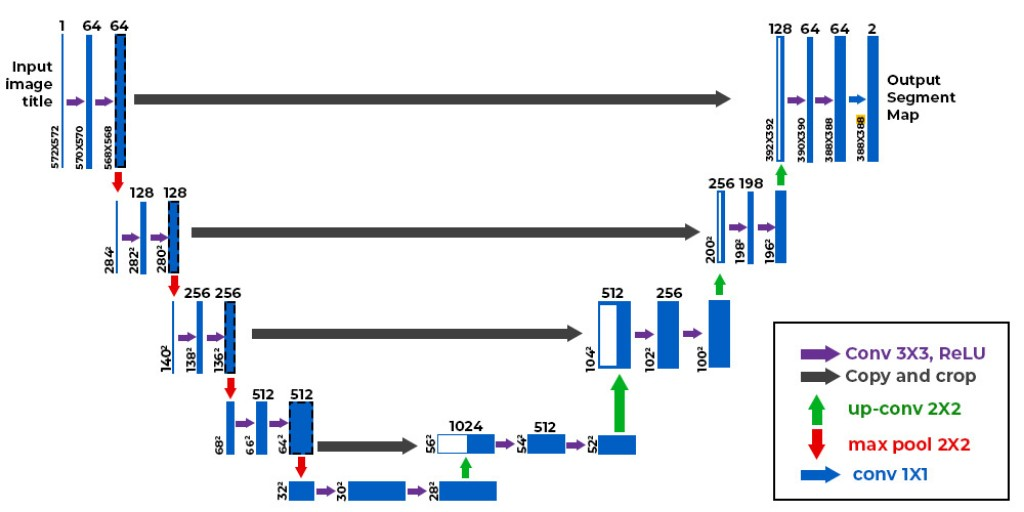

U-Net consists of two main paths: the **Contracting Path** and the **Expansive Path**. It follows an encoder-decoder structure.

## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Explanation of Key Components</p>
1. **Input Layer**: The model starts with an input layer defined by the shape of the images, which in this case is `(256, 256, 1)` for grayscale images.
2. **Contracting Path (Encoder)**:
   - The encoder consists of three convolutional blocks, each followed by ReLU activations and max pooling for downsampling.
   - Each block captures features at increasing levels of complexity, starting from basic features with 64 filters to more complex features with 256 filters.
3. **Bottleneck**:
   - The bottleneck consists of two convolutional layers with 512 filters, which captures the most complex features of the input image.
4. **Expansive Path (Decoder)**:
   - The decoder also has three blocks that mirror the encoder. Each block consists of upsampling followed by concatenation with the corresponding encoder block to retain spatial information.
   - Each upsampling block reduces the number of filters, starting from 256 down to 64.
5. **Output Layer**:
   - The final layer outputs the segmentation map with the same width and height as the input image, using a 1x1 convolution and a sigmoid activation function for binary segmentation.
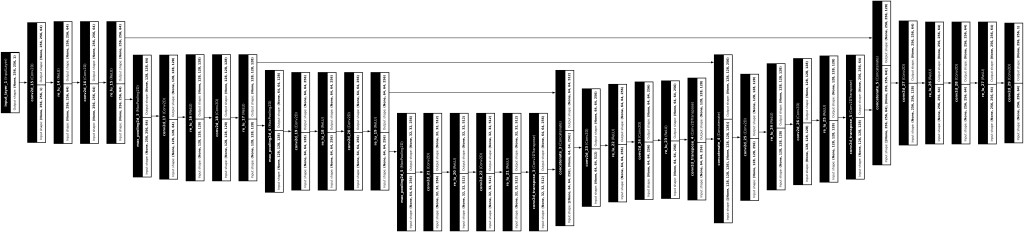

In [ ]:
def unet(input_shape, num_classes):
    # Input layer for the model
    inputs = layers.Input(shape=input_shape)
    
    # Contracting Path (Encoder)
    # First block with 64 filters
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)  # Add Batch Normalization
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)  # Add Batch Normalization
    pool1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1)  # Downsample

    # Second block with 128 filters
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)  # Add Batch Normalization
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)  # Add Batch Normalization
    pool2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)  # Downsample

    # Third block with 256 filters
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)  # Add Batch Normalization
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)  # Add Batch Normalization
    pool3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv3)  # Downsample

    # Bottleneck layer with 512 filters
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)  # Add Batch Normalization
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)  # Add Batch Normalization

    # Expansive Path (Decoder)
    # First upsampling block
    up6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)  # Upsample
    merge6 = layers.concatenate([up6, conv3])  # Concatenate with the corresponding encoder block
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.BatchNormalization()(conv6)  # Add Batch Normalization
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)  # Add Batch Normalization

    # Second upsampling block
    up7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)  # Upsample
    merge7 = layers.concatenate([up7, conv2])  # Concatenate with the corresponding encoder block
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.BatchNormalization()(conv7)  # Add Batch Normalization
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)  # Add Batch Normalization

    # Third upsampling block
    up8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)  # Upsample
    merge8 = layers.concatenate([up8, conv1])  # Concatenate with the corresponding encoder block
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.BatchNormalization()(conv8)  # Add Batch Normalization
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)  # Add Batch Normalization

    # Output layer for segmentation
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(conv8)

    # Create the model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model  # Return the model

# Instantiate the model
input_shape = (512, 512, 1)  # Define the input shape for grayscale images
model = unet(input_shape, 1)  # Create U-Net model for binary segmentation

# Print the model summary
model.summary()  # Display model architecture


# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Loss & Metric Function</p>
### **Binary Cross-Entropy Loss**

**Binary Cross-Entropy (BCE)**, also known as **log loss**, is a loss function commonly used for binary classification tasks, including binary segmentation in image processing. It measures the difference between the predicted probabilities and the actual labels.

### **Formula**

The Binary Cross-Entropy loss for a single sample is given by:

$$
\text{BCE} = - \left[ y \log(p) + (1 - y) \log(1 - p) \right]
$$

Where:
- $ y $ is the actual label (0 or 1) for the given sample (binary class).
- $ p $ is the predicted probability that the sample belongs to class 1 (the "positive" class).
- $ \log $ is the natural logarithm.

For a set of samples, the total loss is the **average BCE** across all samples in the batch:

$$
\text{Total BCE} = \frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$$

Where:
- $ N $ is the total number of samples in the batch.
- $ y_i $ is the actual label for the $ i $-th sample.
- $ p_i $ is the predicted probability for the $ i $-th sample.

- **When the true label is 1**: The first part of the formula $ y \log(p) $ dominates. If the predicted probability $ p $ is close to 1, the loss will be small. If $ p $ is closer to 0, the loss will be large (i.e., high penalty for wrong predictions).

- **When the true label is 0**: The second part of the formula $ (1 - y) \log(1 - p) $ dominates. If the predicted probability $ p $ is close to 0, the loss will be small. If $ p $ is close to 1, the loss will be large.






### **Jaccard Index (IoU)**

The **Jaccard Index**, also known as the **Intersection over Union (IoU)**, is a metric commonly used to evaluate the performance of segmentation models. It measures the overlap between the predicted segmentation mask and the ground truth mask. The formula for the Jaccard Index is:

$$
IoU = \frac{|A \cap B|}{|A \cup B|}
$$

Where:
- $ A $ is the set of pixels in the ground truth mask (`y_true`).
- $ B $ is the set of pixels in the predicted mask (`y_pred`).
- $ |A \cap B| $ is the number of pixels where both the ground truth and the prediction are `1` (i.e., the intersection).
- $ |A \cup B| $ is the total number of pixels where either the ground truth or the prediction is `1` (i.e., the union).

The **Jaccard Index** is a number between 0 and 1, where:
- **0** means no overlap (i.e., poor prediction).
- **1** means perfect overlap (i.e., excellent prediction).

In segmentation tasks, a higher Jaccard Index implies that the model is more accurate in segmenting the relevant objects.

### **`dice_coefficient` Function:**
The `dice_coefficient` function calculates the Dice similarity coefficient (also known as the Dice score), which is a measure of overlap between two binary masks. It gives a value between 0 and 1, where 1 indicates perfect overlap, and 0 indicates no overlap.

- **Flattening and casting**: Similar to `dice_loss`, both the true and predicted masks are flattened. Additionally, both are cast to `float32` to avoid issues with type compatibility during arithmetic operations.
- **Intersection**: The intersection is calculated as the element-wise product of the flattened true and predicted masks, and then summed.
- **Coefficient calculation**: The Dice coefficient is computed as:
  $$
  \text{Dice Coefficient} = \frac{2 \times \text{Intersection} + \text{smooth}}{\text{Sum of True Labels} + \text{Sum of Predicted Labels} + \text{smooth}}
  $$
  A higher Dice coefficient means better model performance in terms of segmentation accuracy.
  
- **Purpose**: The Dice coefficient is a useful metric to evaluate the performance of a segmentation model. The higher the coefficient, the better the overlap between the predicted mask and the ground truth mask.

In [ ]:
# Jaccard Index Metric
def jaccard_index(y_true, y_pred, smooth=100):
    """Calculates the Jaccard index (IoU), useful for evaluating the model's performance."""
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast ground truth
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast predictions
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Compute intersection
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection  # Total pixels
    return (intersection + smooth) / (total + smooth)


def dice_coefficient(y_true, y_pred, smooth=1):
    # Flatten and cast true and predicted masks to float32
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast y_true to float32
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast y_pred to float32
    
    # Calculate the intersection between the true and predicted masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    
    # Calculate the Dice coefficient using the formula
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


# Using the metrics in model compilation
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy',dice_coefficient,jaccard_index])

# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Train The Model</p>

In [ ]:
## ModelCheckpoint: Save the model with the best validation loss during training
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Path to save the model
    monitor='val_dice_coefficient',         # Metric to monitor 
    verbose=1,                  # Print messages when saving the model
    save_best_only=True,        # Save only the best model (with highest metric)
    mode='max',                 # 'max' means the model with the highest metric score will be saved
    save_weights_only=False,     # Save the entire model (not just weights)
)

# Fit the model with multi-processing enabled
history = model.fit(
    train_data,                  # The training data generator or dataset
    validation_data=val_data,  # Validation data ratio 
    epochs=128,              # Number of epochs
    callbacks=[checkpoint],# Callbacks for checkpoint and early stopping
)

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(222)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.subplot(223)
plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Model Dice Coefficient')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.subplot(224)
plt.plot(history.history['jaccard_index'], label='Train Jaccard Index')
plt.plot(history.history['val_jaccard_index'], label='Validation Jaccard Index')
plt.title('Model Jaccard Index')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [ ]:
imgs, msks  = val_data.__getitem__(1)

for img,msk in zip(imgs,msks):
    img = np.expand_dims(img, axis=0)
    pred = (np.squeeze(model.predict(img,verbose=0))*255).astype(np.uint8)
    img = (np.squeeze(img) * 255).astype(np.uint8)
    msk = (msk*255).astype(np.uint8)

    # Convert grayscale image to RGB
    img= cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    msk = cv2.cvtColor(msk, cv2.COLOR_GRAY2RGB)
    pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)
    
    plt.figure(figsize=(12,4))

    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)
    
    plt.subplot(132)
    plt.imshow(get_colored_mask(img,msk))
    plt.title('Mask (Actual)')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(133)
    plt.imshow(get_colored_mask(img,pred,color = [255,30,0]))
    plt.title('Mask (Prediction)')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.tight_layout()
    plt.show()